## Training to retrieve beliefs for dialogs

**Goal:** Train an embedding model to match dialogs with beliefs and facts
**Method:**
- [x] Use bge_small_en_15 model as base
- [x] Use stacked_samsum + dialogsum as datasets
- [x] Prepare datasets
    - [x] remove unnecessary columns
    - [x] remove '#' from dialogsum
    - [x] expand the stacked dataset
    - [x] truncate on the left to 512 tokens
    - [x] combine and train_test_split
- [x] evaluate embedding similarity using base on test split
    - [x] calc embeddings
    - [x] calc cosine scores
    - [x] visualize using matplotlib
- [x] finetune the model on train dataset
    - [x] add prefix as necessary
- [ ] Evaluate the final model on the test-set
- [ ] Compare results

### Imports and utils

In [1]:
model_name = "BAAI/bge-small-en-v1.5"
query_prefix = "Represent this sentence for searching relevant passages:"
max_len = 512
next_concept_sep = "\n[NEXT_CONCEPT]\n"
training_input_data = "./data/output.jsonl"
training_hn_data = "./data/hn-output.jsonl"

### Constants

In [2]:
%matplotlib inline

from functools import partial
import os
import random

from datasets import load_dataset, concatenate_datasets
from FlagEmbedding import FlagModel
from FlagEmbedding.baai_general_embedding.finetune.hn_mine import find_knn_neg
import jsonlines as jsonl
import matplotlib.pyplot as plt
import numpy as np
from numpy import dot
from numpy.linalg import norm
from tqdm.auto import tqdm
from transformers import AutoTokenizer

os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2"
tokenizer = AutoTokenizer.from_pretrained(model_name)

### Datasets

#### Initial run

- stacked_samsum: to be used as training
- dialogsum: to be used as testing

#### Final run

- combined: stacked_samsum + dialogsum

In [3]:
datasets = {
    "stacked_samsum": load_dataset(
        "stacked-summaries/stacked-samsum-1024", 
        split="train+validation+test",
    ).remove_columns(['chapter_length', 'summary_length', 'is_stacked',]).filter(
        lambda row: row["dialogue"]
    ).map(
        lambda row: dict(dialogue=row["dialogue"].replace("\r\n", '\n'))
    ),
    "dialogsum": load_dataset(
        "knkarthick/dialogsum", 
        split="train+validation+test",
    ).remove_columns(["id", "topic"]).map(
        lambda row: dict(dialogue=row["dialogue"].replace("#", ''))
    ),
}

In [4]:
def count_tokens(row):

    dialogue = row["dialogue"]
    tokens = tokenizer.encode(dialogue, add_special_tokens=False)

    return dict(token_count=len(tokens))

datasets["stacked_samsum"] = datasets["stacked_samsum"].map(count_tokens)
datasets["dialogsum"] = datasets["dialogsum"].map(count_tokens)

In [5]:
def truncate_dir(dialogue, left=False):
    lines = dialogue.split("\n")
    
    toks_by_line = [
        len(tokenizer.encode(line, add_special_tokens=False))
        for line in lines
    ]

    idx = 0 if left else -1
    
    while sum(toks_by_line) > max_len:
        toks_by_line.pop(idx)
        lines.pop(idx)

    return "\n".join(lines)

def expand_stacked(rows):
    dialogues = rows["dialogue"]
    summaries = rows["summary"]

    final_dialogues = []
    final_summaries = []
    
    for dialogue, summary in zip(dialogues, summaries):
        
        ss = summary.split(next_concept_sep)
        dd = [
            truncate_dir(dialogue, left=(i >= (len(ss) // 2)))
            for i in range(len(ss))
        ]

        final_dialogues += dd
        final_summaries += ss

    return dict(
        dialogue=final_dialogues,
        summary=final_summaries,
        token_count=[None]*len(final_summaries),
    )

datasets["stacked_samsum"] = datasets["stacked_samsum"].map(expand_stacked, batched=True).remove_columns(["token_count"])

In [6]:
combined = concatenate_datasets(list(datasets.values()))

In [7]:
combined = combined.train_test_split(test_size=0.1)

### Embed using base model (before tuning)

In [15]:
def embed(rows, model_name=model_name, query_prefix=query_prefix):
    from FlagEmbedding import FlagModel

    model = FlagModel(
        model_name,
        query_instruction_for_retrieval=query_prefix,
        use_fp16=False,
    )

    dialogues = rows["dialogue"]
    summaries = rows["summary"]

    dialogue_embs = model.encode(dialogues).tolist()
    summary_embs = model.encode_queries(summaries).tolist()

    return dict(
        dialogue_emb=dialogue_embs,
        summary_emb=summary_embs,
    )

In [16]:
base_eval_ds = combined["test"].map(embed, batched=True)

Map:   0%|          | 0/13968 [00:00<?, ? examples/s]

----------using 2*GPUs----------



Inference Embeddings: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.22s/it]

Inference Embeddings: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.69it/s]


----------using 2*GPUs----------



Inference Embeddings: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.25s/it]

Inference Embeddings: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.20it/s]


----------using 2*GPUs----------



Inference Embeddings: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.25s/it]

Inference Embeddings: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.25it/s]


----------using 2*GPUs----------



Inference Embeddings: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.26s/it]

Inference Embeddings: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.05it/s]


----------using 2*GPUs----------



Inference Embeddings: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.26s/it]

Inference Embeddings: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.69it/s]


----------using 2*GPUs----------



Inference Embeddings: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.30s/it]

Inference Embeddings: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.01it/s]


----------using 2*GPUs----------



Inference Embeddings: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.30s/it]

Inference Embeddings: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.03it/s]


----------using 2*GPUs----------



Inference Embeddings: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.40s/it]

Inference Embeddings: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.92it/s]


----------using 2*GPUs----------



Inference Embeddings: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.52s/it]

Inference Embeddings: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.01it/s]


----------using 2*GPUs----------



Inference Embeddings: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.59s/it]

Inference Embeddings: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.20it/s]


----------using 2*GPUs----------



Inference Embeddings: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.70s/it]

Inference Embeddings: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.18it/s]


----------using 2*GPUs----------



Inference Embeddings: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.61s/it]

Inference Embeddings: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.19it/s]


----------using 2*GPUs----------



Inference Embeddings: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.56s/it]

Inference Embeddings: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.99it/s]


----------using 2*GPUs----------



Inference Embeddings: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.52s/it]

Inference Embeddings: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.81it/s]


In [9]:
def calc_cos_sim(row):
    dialogue_emb = row["dialogue_emb"]
    summary_emb = row["summary_emb"]

    a = np.array(dialogue_emb)
    b = np.array(summary_emb)

    cos_sim = dot(a, b)/(norm(a)*norm(b))

    return dict(similarity=cos_sim)

In [17]:
base_eval_ds = base_eval_ds.map(calc_cos_sim, num_proc=40)

Map (num_proc=40):   0%|          | 0/13968 [00:00<?, ? examples/s]

### Evaluation (before tuning)

1

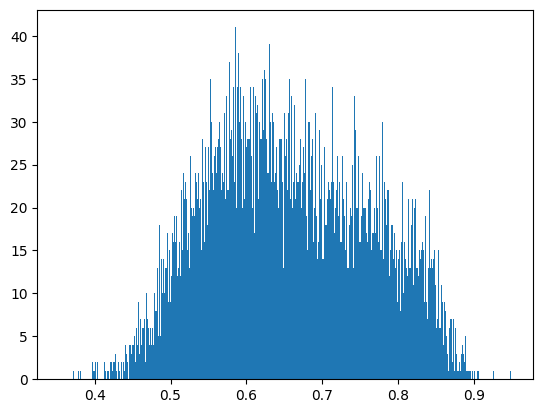

In [18]:
plt.hist(base_eval_ds["similarity"], bins=1000); 1

### Prepare dataset for finetuning
[Docs](https://github.com/FlagOpen/FlagEmbedding/tree/master/examples/finetune)

Format:
```json
{"query": str, "pos": List[str], "neg":List[str]}
```

Keys:
- query: belief
- pos: list of matching conversations
- neg: list of random conversations from dataset

In [13]:
def pick_random(ds=combined["train"], far_from=0):
    ds_len = len(ds)
    mid = ds_len // 2
    which_half = far_from // mid
    
    start = (1 - which_half) * mid
    end = ds_len - which_half * mid
    idx = random.randrange(start, end)
    
    return ds[idx]

In [14]:
with jsonl.open(training_input_data, mode='w') as writer:
    for i, row in enumerate(tqdm(combined["train"], total=len(combined["train"]))):
        query = row["summary"]
        pos = [row["dialogue"]]
    
        neg = [
            pick_random(far_from=i)["dialogue"]
            for _ in range(3)
        ]
        
        writer.write(dict(query=query, pos=pos, neg=neg))

  0%|          | 0/125705 [00:00<?, ?it/s]

### Mine hard negatives

In [15]:
model = FlagModel(
    model_name,
    query_instruction_for_retrieval=query_prefix,
)

----------using 3*GPUs----------


In [16]:
find_knn_neg(
    model,
    input_file=training_input_data,
    candidate_pool=None,
    output_file=training_hn_data,
    sample_range=list(range(2, 200)),
    negative_number=15,
    use_gpu=True,
)

inferencing embedding for corpus (number=51135)--------------


Inference Embeddings: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [01:45<00:00,  1.58s/it]


inferencing embedding for queries (number=125705)--------------


Inference Embeddings: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 164/164 [00:46<00:00,  3.54it/s]


create index and search------------------


Batches: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1965/1965 [00:04<00:00, 428.59it/s]


### Finetune

In [10]:
# Done separately on command line

### Visualize results (after tuning)

In [19]:
embed_with_trained = partial(embed, model_name="./model")
final_eval_ds = combined["test"].map(embed_with_trained, batched=True)

Map:   0%|          | 0/13968 [00:00<?, ? examples/s]

----------using 2*GPUs----------



Inference Embeddings: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.55s/it]

Inference Embeddings: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.06it/s]


----------using 2*GPUs----------



Inference Embeddings: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.56s/it]

Inference Embeddings: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.90it/s]


----------using 2*GPUs----------



Inference Embeddings: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.63s/it]

Inference Embeddings: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.78it/s]


----------using 2*GPUs----------



Inference Embeddings: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.69s/it]

Inference Embeddings: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.74it/s]


----------using 2*GPUs----------



Inference Embeddings: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.77s/it]

Inference Embeddings: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.86it/s]


----------using 2*GPUs----------



Inference Embeddings: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.73s/it]

Inference Embeddings: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.67it/s]


----------using 2*GPUs----------



Inference Embeddings: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.78s/it]

Inference Embeddings: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.65it/s]


----------using 2*GPUs----------



Inference Embeddings: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.77s/it]

Inference Embeddings: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.70it/s]


----------using 2*GPUs----------



Inference Embeddings: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.78s/it]

Inference Embeddings: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.09it/s]


----------using 2*GPUs----------



Inference Embeddings: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.77s/it]

Inference Embeddings: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.09it/s]


----------using 2*GPUs----------



Inference Embeddings: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.77s/it]

Inference Embeddings: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.05it/s]


----------using 2*GPUs----------



Inference Embeddings: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.77s/it]

Inference Embeddings: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.88it/s]


----------using 2*GPUs----------



Inference Embeddings: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.76s/it]

Inference Embeddings: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.90it/s]


----------using 2*GPUs----------



Inference Embeddings: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.67s/it]

Inference Embeddings: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.46it/s]


In [20]:
final_eval_ds = final_eval_ds.map(calc_cos_sim, num_proc=40)

Map (num_proc=40):   0%|          | 0/13968 [00:00<?, ? examples/s]

1

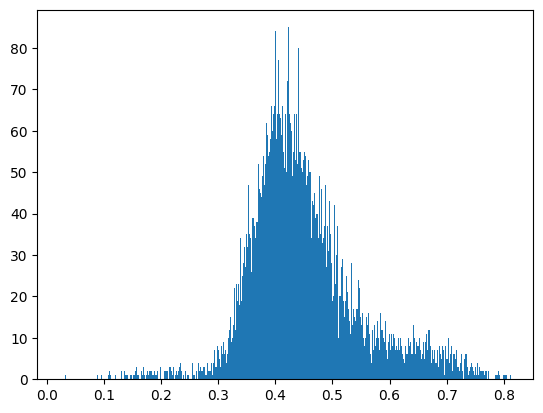

In [21]:
plt.hist(final_eval_ds["similarity"], bins=1000); 1